# Sales forecasting 

## In this project I'm going to attemp a forecasting on a dataset that shows sales of clothing goods up until the end of 2019 (The dataset on the website contains the values up until 2022, but the Covid year had a great influence on the sales and it really affects the predictions of my model, so I decided to cut out the covid years from my dataset). I will forecast one year and a half into the future to see if the model is able to maintain the pre-estabilished trends. 

**A forecast cannot be evaluated as right or wrong, since it's unknown data from the future, hence I will first split the dataset into training and testing parameters, and if I am pleased with the performance of my model on this data I will use it to create a forecast.**

**Regarding the model, I thught about using a recurrent neural network, with one or a few layers of LSTM cells (long-short term memory cells) rather then simple recurrent neurons. Why? Beacuse the LSTM cells have much better performance given the fact that they can keep track of mostly all outputs (if choosen not to be forgotten by th cell) before their own output (this is called the long memory term). The activation function for the cell layer will be a rectified linear unit, beacuse I want to deal from the beginning with possible vanishing or exploding gradients. Finally for the output part of the network I will chose to have a single Dense neuron, because the output value is a continuous one. For optimization of the gradient and backpropagation I will use the 'adam' optimizer and to keep track of my loss function I will use the mean squared error 'mse'**

**The Data**

The dataset was found and imported from the 'FRED Economic Data' page, it can be seen here: https://fred.stlouisfed.org/series/MRTSSM448USN

This dataset basically represents the following: Retail Sales: Clothing and Clothing Accessory Stores, which contains the sales statistics of the said products until October 2019.

**All being said, let's try to forecast the sales!**

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Read the data and make sure the date column is in datetime format
df = pd.read_csv('Clothing sales.csv', parse_dates = True, index_col = 0)

In [3]:
#Let's check out the data
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
#Check if the dtypes are ok and if we don't have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
#Next step is to change that code name column to a simple 'Sales'
df.columns = ['Sales']

<AxesSubplot: xlabel='DATE'>

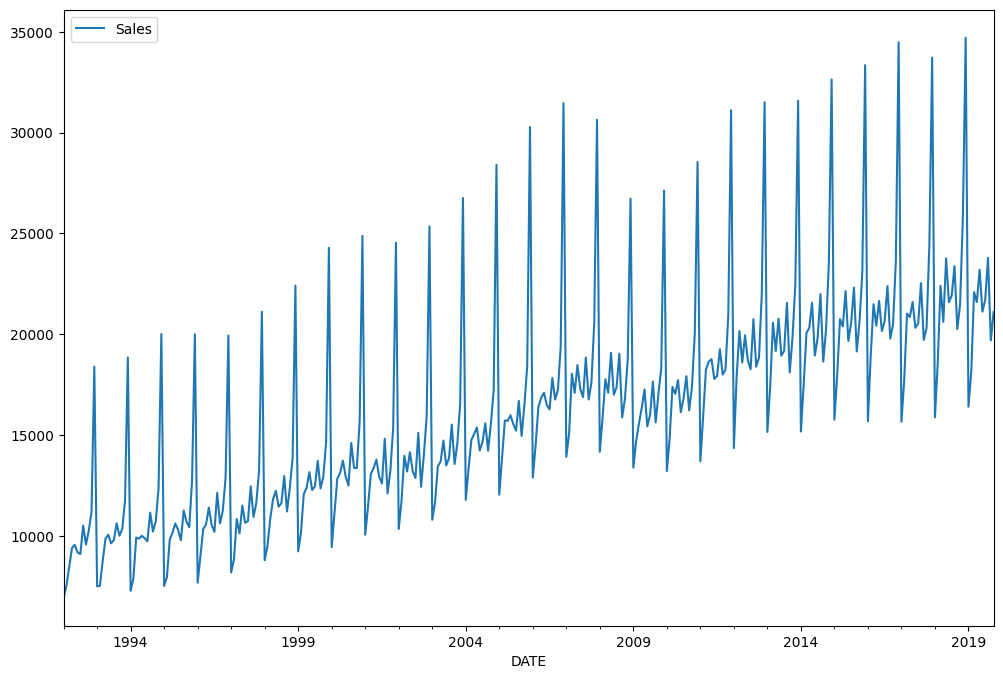

In [6]:
#Let's check the data out visually:
df.plot(figsize = (12,8))

(564.0, 588.0)

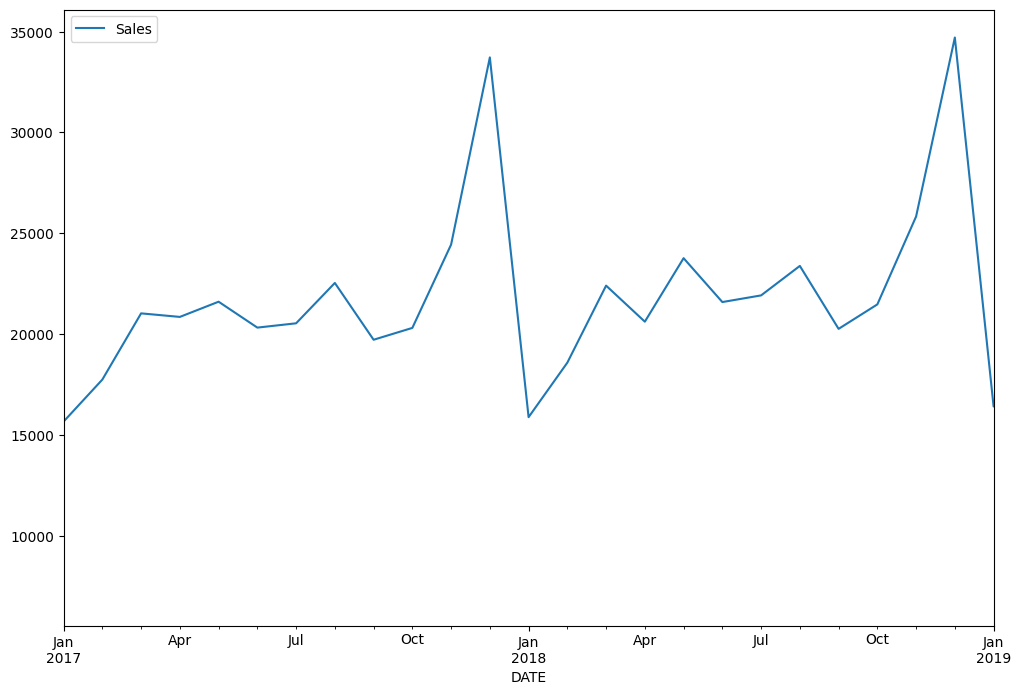

In [7]:
#Now for a shorter period
df.plot(figsize = (12,8))
plt.xlim('2017-01-01', '2019-01-01')

We can see that there is a trend that most clothing pieces are sold during the winter holidays (being Christmas), so I expect my model to catch up on this trend

- In the next few steps I wil establish the dimensions of the training and testing data and split them using simple, intuitive indexing

In [8]:
len(df)

334

The dataset has sales values on a monthly basis, so 12 entries a year. The dataset has a pretty long record, tracking the sales from the 90' up until october 2019. My decision and reasoning is that if I leave all the data until 2018 to train the model, and then I test for the remaining year and 6 months (so the rest of 2018 and until october 2019)

In [9]:
test_size = 18 #utterly my decision, could be honestly more or less, it's up to each one

In [10]:
#Now to see where to slice the df
test_ind = len(df) - test_size

In [11]:
train = df.iloc[:test_ind] #all entries until but not included test_ind value
test = df.iloc[test_ind:] #all remaining is for testing

In [12]:
train #as we can see it goes until april 2018

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [14]:
#To feed the data to the model we have to scale it as usual:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

The next step implies a total new step in comparison to my other project, and that is a timeseries generator. So I am basically telling my model, that I want batches of different length of training/test data to be fed to the model. A rather simple example for this step is that I create a generator of length = 12. So what this means is that I am telling the model to grab the previous 12 datapoints and based on this 12 the 13th one. In time-series, as this dataset, the generator works well with a length of 12 inputs, because that covers a whole year of sales.

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 12
batch_size = 1 #I want one batch at a time

generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train,
                               length = length, batch_size = batch_size)

- both data and targets labels (X and y) are found in the scaled training data
- let me present exactly wht this genertor does:

In [17]:
X,y = generator[0] #this is the first generated batch

In [18]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

Bascially, given this batch of 12 datapoints, predict the 13th

In [19]:
y

array([[0.02047633]])

In [20]:
#And if we look at the first 13 elements of the scaled training data:
scaled_train[:13]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633]])

We can see that the y label is exactly the next element in that array

In [21]:
#Let's create a validation genertor on the same principle:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

**Now that we have scaled the data and created batch generators, we can build the model**

As I said in the introduction, I will be using a recurrent neural network, but before using LSTM cells I would like to try the performance of the model with simple recurrent neurons (without updating the long-term memory) and then trying to improve it with LSTM cells. The model type is going to be sequential, feeding the data all the way from the input to the output and I am going to use the 'relu' activation function to avoid problems with the backpropagation and vanishing gradients (for the simpleRNN I amgoing to chose the classic tanh) and to optimize the gradient descent I am going to use an adapative gradient descent, the 'adam'.

Let's see how we perform!

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [23]:
#We have to establish the number of features that we give the model, and that being only sales, we just have 1:
nr_features = 1

In [24]:
model = Sequential()

""""Given the fact that the training data has 300+ entries, 
the literature shows that a great number for neurons in the recurrent layer would be aproximately 
a third from that number, but this is at your own choice"""

model.add(SimpleRNN(150, input_shape = (length, nr_features)))


#Output

model.add(Dense(1))

model.compile(optimizer='adam', loss = 'mse')

In [25]:
#Also add an early_stop if we start to overfit 
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [26]:
#Fit the model and start the training
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Leon\AppData\Local\Temp\ipykernel_1948\201297875.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 2s 4ms/step - loss: 0.0102 - val_loss: 0.0038
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0134
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0079
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0084 - val_loss: 0.0018
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0195
Epoch 6/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0133 - val_loss: 0.0039
Epoch 7/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 8/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0055 - val_loss: 0.0066


In [27]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

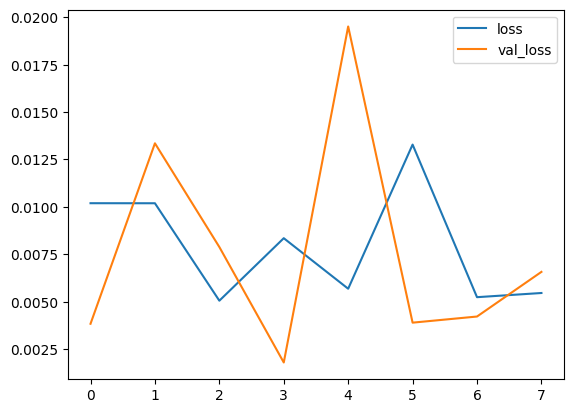

In [28]:
losses.plot()

- we can see that the losses of the model using a simpleRNN are all over the place and it doesn't have the capacities to perform well on this kind of datasets

- Now to actually make the predictions, it gets a little tricky

In [29]:
#Create a prediction list

predictions = []

#Let's define the first batch to make predictions on

first_batch = scaled_train[-length:]

#Now we have to reshape the input in the way the model expects it:(1 batch, length, nr_features)

current_batch = first_batch.reshape(1, length, nr_features)

"""Now I want to create a forward moving loop, that ends up predicting on predictions,
so after each prediction made, I eliminate the first element of the list and append the prediction 
to the list, which is then used to predict the next one and so on"""

for i in range(len(test)):
    
    # We a getting the prediction only 1 time-stamp ahead, an only grabbing the number
    current_pred = model.predict(current_batch)[0]
    
    #I store this prediction in the list:
    predictions.append(current_pred)
    
    #This next line includes the prediction to the list and eliminates the first element for each loop
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [30]:
#Remeber that these are scaled values, so we have to un-scale them
predictions = scaler.inverse_transform(predictions)

In [31]:
#Now add this new predicted column to the test df and plot it out:
test['Predictions'] = predictions

C:\Users\Leon\AppData\Local\Temp\ipykernel_1948\2904110467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


<AxesSubplot: xlabel='DATE'>

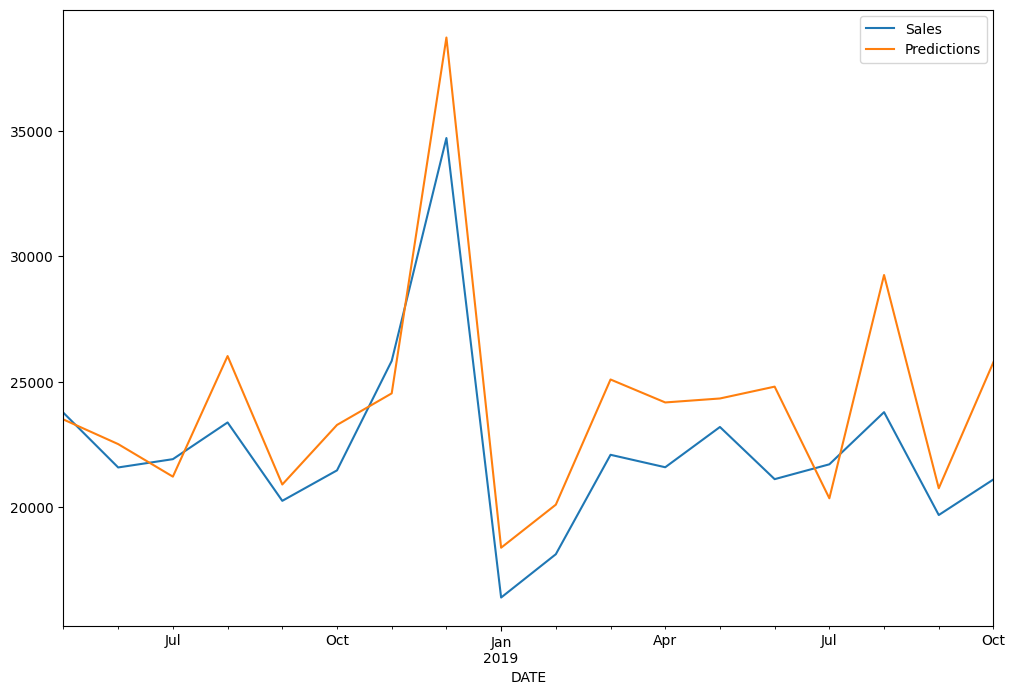

In [32]:
test.plot(figsize = (12,8))

In [33]:
#Evaluating the prediction using root mean squared error
from sklearn.metrics import mean_squared_error

In [34]:
np.sqrt(mean_squared_error(test['Sales'],test['Predictions']))

2611.102663648989

Surprisingly the prediction isn't really that far off, given the type of the used neurons. The RMSE tells us that that we are off with an average of 2611 dollars. Given the fact that the values of sales are over the 10000s, the RMSE has a reasonable value. So this simple model isn't that bad s I thought it would be.

**Let's see how can we improve it using LSTM cells**

- Basically an LSTM cell should work far better than a simple recurrent neuron, because of the 4 gates that it possesses. Firstly we have the input gate, which is the normal input at a timepoint t. Then we have the forget gate, that deals with the long-term memory inputs that get to the cell and decides which information to keep and which to forget. We have then the update gate and output gate which sends the important information to the next cell. This gates are connected to one-another through sigmoidal and tanh functions, basically if an input is closer to 0 will be forgotten, if it is 1 or -1 (or close to) it will run through the cell where it will be activated by different functions. In conclusion, it should work far better the the previous model. Let's run it!

In [35]:
model = Sequential()

model.add(LSTM(180, activation = 'relu', input_shape = (length, nr_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [36]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Leon\AppData\Local\Temp\ipykernel_1948\3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 4s 8ms/step - loss: 0.0262 - val_loss: 0.0038
Epoch 2/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0167 - val_loss: 0.0020
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0108 - val_loss: 0.0234
Epoch 4/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0047 - val_loss: 0.0144
Epoch 5/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 6/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 8/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0015 - val_loss: 5.9913e-04
Epoch 9/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 3.7156e-04
Epoch 10/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 3.3883e-0

In [37]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

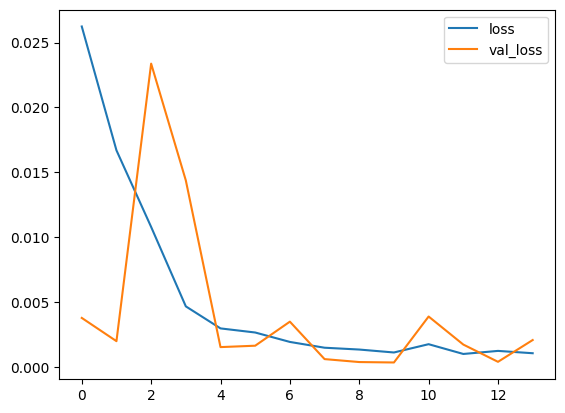

In [38]:
losses.plot()

This loss graph looks much better in this case, and we can see that the model is actually learning along the epochs.

In [39]:
predictions = []

#Let's define the first batch to make predictions on

first_batch = scaled_train[-length:]

#Now we have to reshape the input in the way the model expects it:(1 batch, length, nr_features)

current_batch = first_batch.reshape(1, length, nr_features)

"""Now I want to create a forward moving loop, that ends up predicting on predictions,
so after each prediction made, I eliminate the first element of the list and append the prediction 
to the list, which is then used to predict the next one and so on"""

for i in range(len(test)):
    
    # We a getting the prediction only 1 time-stamp ahead, an only grabbing the number
    current_pred = model.predict(current_batch)[0]
    
    #I store this prediction in the list:
    predictions.append(current_pred)
    
    #This next line includes the prediction to the list and eliminates the first element for each loop
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


C:\Users\Leon\AppData\Local\Temp\ipykernel_1948\1565885860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Prediction'] = predictions


<AxesSubplot: xlabel='DATE'>

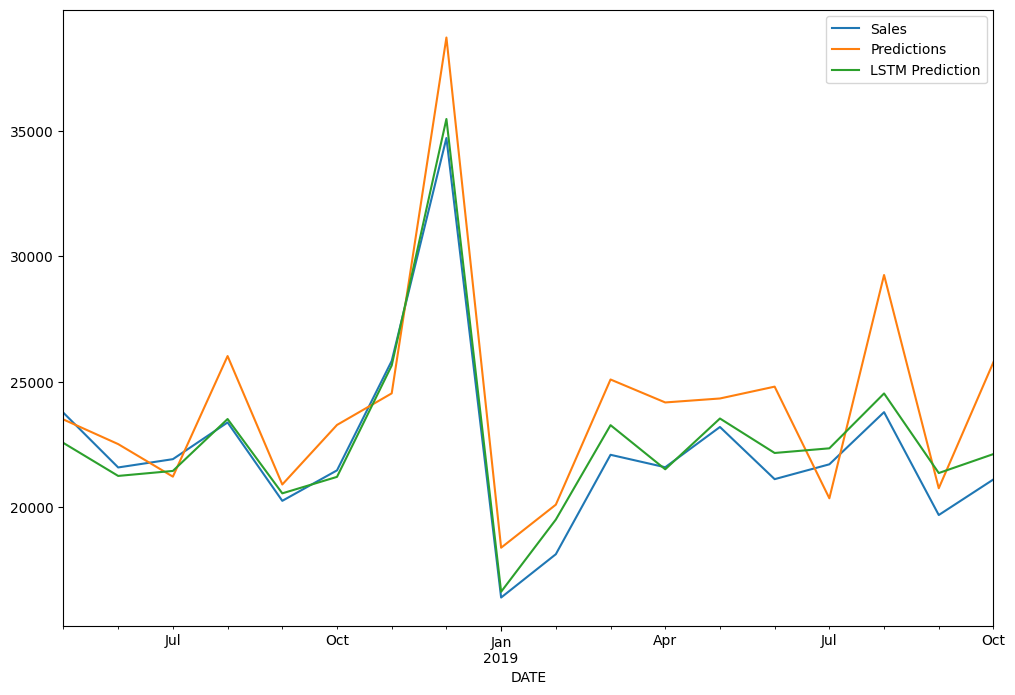

In [40]:
predictions = scaler.inverse_transform(predictions)
test['LSTM Prediction'] = predictions
test.plot(figsize=(12,8))

In [41]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Sales'],test['LSTM Prediction']))

812.488844905669

**Discussion**: We can clearly see that the use of LSTM cells produces much better predictons (green line) and the model actually picks up in all the sales trends (mimicks all the spikes on the graph). The RMSE value is three times smaller than on the previous model, so I am pleased with the performance of this model (this didn't work that well on the first try, I played around with the number of cells, activation function and other parameters, such as the length of training batches etc., but I didn't put all the tries in the notebook not to bore the reader).

**I am confident to do forecasts using this model!**

The difference for forecasts is that we scale all the data, because we are doing a prediction into the future and we need the model to have all the given parameters to learn on:

In [42]:
total_scaler = MinMaxScaler()
scaled_total_data = total_scaler.fit_transform(df)

We create a generator for all the scaled data, but not a validation generator, because we dn't have any data to validate on

In [44]:
generator = TimeseriesGenerator(scaled_total_data, scaled_total_data, length=length, batch_size=1)

In [45]:
model = Sequential()

model.add(LSTM(180, activation = 'relu', input_shape = (length, nr_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Again, by training on all the data, we cannot add an early stop, but we can put the number of epochs that the model needed n the first place to run

In [46]:
model.fit_generator(generator, epochs = 14)

Epoch 1/14


C:\Users\Leon\AppData\Local\Temp\ipykernel_1948\3581574120.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 14)


322/322 [==============================] - 4s 8ms/step - loss: 0.0235
Epoch 2/14
322/322 [==============================] - 2s 7ms/step - loss: 0.0153
Epoch 3/14
322/322 [==============================] - 2s 6ms/step - loss: 0.0066
Epoch 4/14
322/322 [==============================] - 2s 8ms/step - loss: 0.0040
Epoch 5/14
322/322 [==============================] - 2s 7ms/step - loss: 0.0024
Epoch 6/14
322/322 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 7/14
322/322 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 8/14
322/322 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 9/14
322/322 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 10/14
322/322 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 11/14
322/322 [==============================] - 2s 7ms/step - loss: 0.0017
Epoch 12/14
322/322 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 13/14
322/322 [===============

In [47]:
forecast = []

periods = 12 #if we forecast too much into the future it will get noisy, as the model it predicting on other predictions

#Let's define the first batch to make predictions on

first_batch = scaled_train[-length:]

#Now we have to reshape the input in the way the model expects it:(1 batch, length, nr_features)

current_batch = first_batch.reshape(1, length, nr_features)

"""Now I want to create a forward moving loop, that ends up predicting on predictions,
so after each prediction made, I eliminate the first element of the list and append the prediction 
to the list, which is then used to predict the next one and so on"""

for i in range(periods):
    
    # We a getting the prediction only 1 time-stamp ahead, an only grabbing the number
    current_pred = model.predict(current_batch)[0]
    
    #I store this prediction in the list:
    forecast.append(current_pred)
    
    #This next line includes the prediction to the list and eliminates the first element for each loop
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [49]:
forecast = total_scaler.inverse_transform(forecast)

In [50]:
forecast

array([[22705.15990496],
       [21242.05158997],
       [21484.63158178],
       [23543.50867701],
       [20369.2104969 ],
       [21263.53977633],
       [25808.09837198],
       [35938.06769276],
       [16068.54604387],
       [19282.42763805],
       [23469.19295216],
       [21657.5069623 ]])

We need to index these values with datetime data. Lucky for us pandas has a very helpful function:

In [51]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [52]:
#The df ends on 2019-10-01, so the forecast has to begin after that:
forecast_index = pd.date_range(start = '2019-11-01', periods=periods, 
                              freq = 'MS') #MS means monthly start (frequency calls documentation)

In [53]:
forecast_df = pd.DataFrame(forecast, forecast_index, columns= ['Forecast'])

**Let's plot out a final forecast for this dataset:**

<AxesSubplot: xlabel='DATE'>

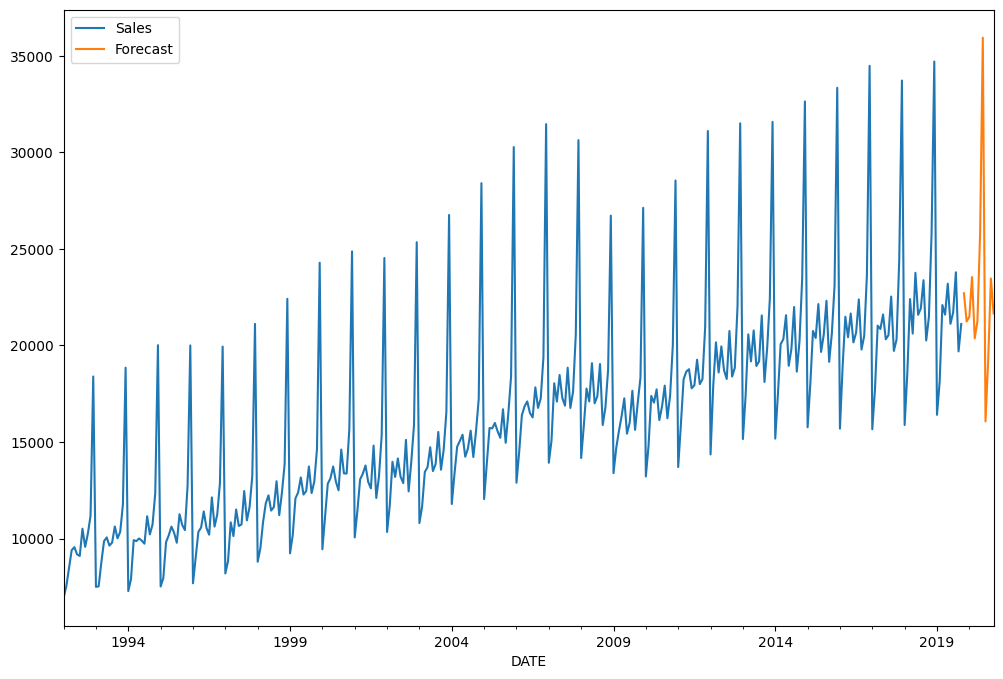

In [55]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize = (12,8))

(564.0, 611.0)

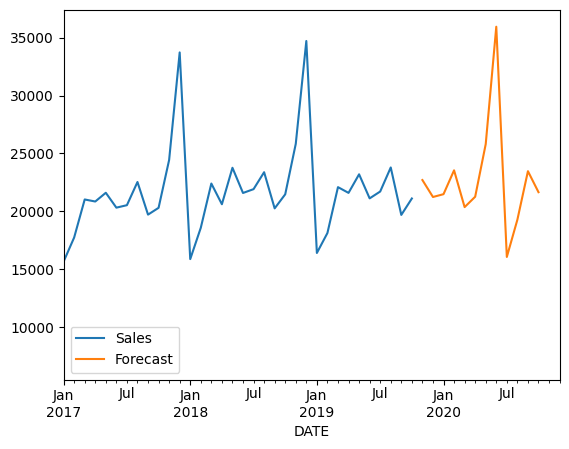

In [56]:
#For a closer look:
ax = df.plot() 
forecast_df.plot(ax=ax)
plt.xlim('2017-01-01', '2020-12-01')

We can see that the forecast makes sense and respects all the trends of the previous years. So this is what the sales for this clothing line should have looked in 2020, but as we all know covid-19 hit and I can show you now the real sales just to hav an idea how much covid influenced each industry

In [57]:
df2 = pd.read_csv('MRTSSM448USN.csv',parse_dates = True, index_col = 0)

In [58]:
df2.columns = ['Sales']

(564.0, 611.0)

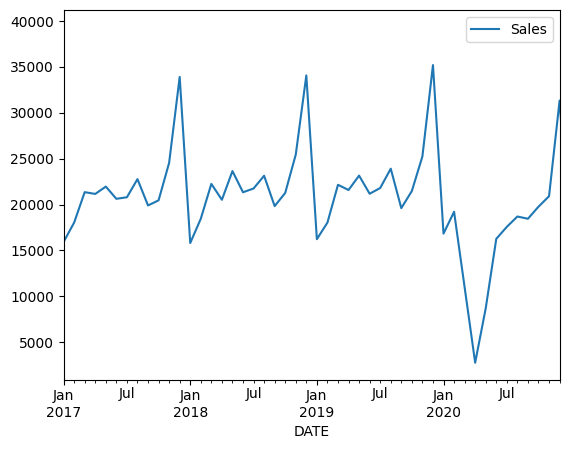

In [60]:
df2.plot()
plt.xlim('2017-01-01', '2020-12-01')

## As a conclusion I can say that the model using LSTM cells worked far better, it surely can work even better, but for this project it did it's job really well. I hope you enjoyed this project and I showed you that I can be a good addition to your team!